In [2]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from util import util
import os
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt

# Load data
data_file = os.path.join('data', 'er.csv')
data = util.load_ed_data(data_file)

# Hourly code counts
codes = pd.get_dummies(data['Code'])
codes.set_index(data['Triage'], inplace=True)
codes.columns = codes.columns.to_list()
codes_b = codes.resample('H').sum()

# Compute totals
cols = ['white', 'green', 'yellow', 'red']
codes_b['total'] = codes_b[cols].sum(axis=1)

# Add time information
codes_bt = codes_b.copy()
codes_bt['month'] = codes_bt.index.month
codes_bt['weekday'] = codes_bt.index.weekday
codes_bt['hour'] = codes_bt.index.hour

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Arrival Prediction

## Arrival Prediction

**We can now frame our arrival prediction problem**

We want to predict the number of arrivals in the next interval

* We will focus on predicting the _total number of arrivals_
* The same models can be applied to any of the individual counts

**This is a _regression_ problem**

...Which normally is tackled by using an MSE loss

* However, this is not always the best choice
* ...Since the correct loss depends on the data distribution

## Which Distribution

**We might be tempted to:**

* Consider the target attribute (e.g. number of arrivals in bin)
* Run a statistical tests for multiple distributions

...But it is _technically wrong_

**...Since regressors are trained to learn a _conditional_ distribution**

Therefore, what we should do instead is:

* _Partition the target data_ based on the value of one or more relevant features
* ...Then proceed as above for each group

**Unfortunately, this is tricky in practice**

* What if we don't know which features are important?
* What if there are a lot of relevant features

In practice, the first approach is often used as an approximation

## Analyzing the Conditional Arrival Distribution

**...But in our case we know that the hour of the day is a good predictor**

Let's check the (conditional) distribution for a few values (here 6m):

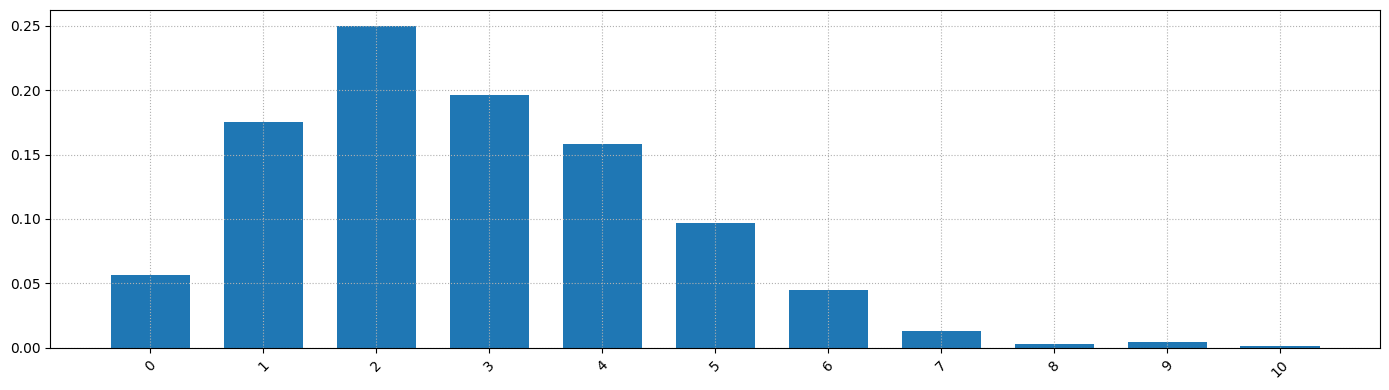

In [3]:
tmp = codes_b[codes_b.index.hour == 6]['total']
tmpv = tmp.value_counts(sort=False, normalize=True).sort_index()
util.plot_bars(tmpv, figsize=figsize)

* This is _not_ a normal distribution

## Poisson Distribution

**When we need to _count occurrences over time_...**

It's almost always worth checking the _Poisson distribution_, which models:

* The number of occurrences of a certain event in a given interval
* ...Assuming that these events are _independent_
* ...And they occur at a _constant rate_

**In our case:**

* The independence assumption is reasonable (arrivals do not affect each other)
* The constant rate is true _for the conditional probability_
* ...Assuming that we condition using the right features
* I.e. those that have an actual correlation with the arrivals

## Poisson Distribution

**The Poisson distribution is defined by a single parameter $\lambda$**

$\lambda$ is the rate of occurrence of the events

* The distribution has a _discrete support_
* The Probability Mass Function is:
$$
p(k, \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}
$$
* Both the _mean_ and the _standard deviation_ have the same value (i.e. $\lambda$)
* The distribution skewness is $\lambda^{-\frac{1}{2}}$
  - For low $\lambda$ values, there is a significant positive skew (to the left)
  - The distribution becomes less skewed for large $\lambda$

## Fitted Poisson Distribution

**Let's try to fit a Poisson distribution over our target**

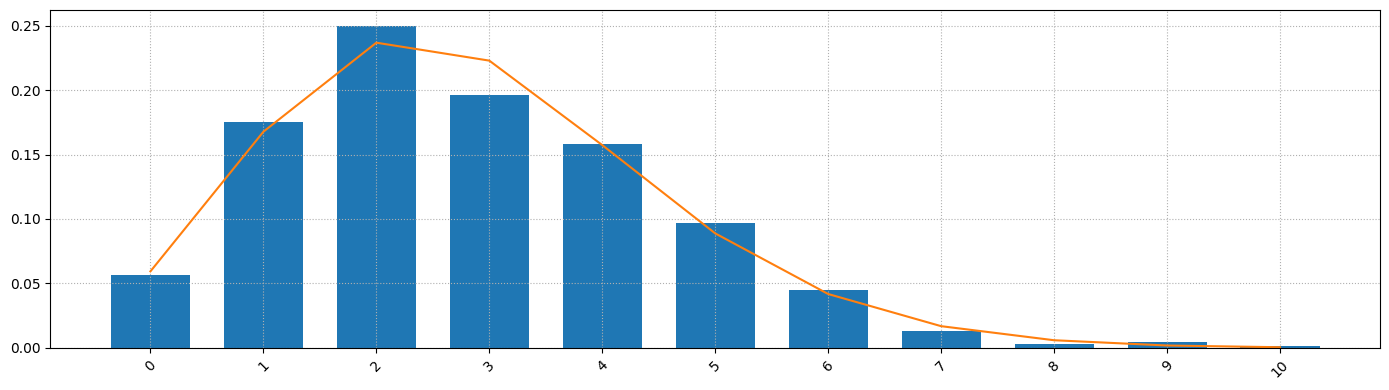

In [4]:
mu = tmp.mean()
dist = stats.poisson(mu)
x = np.arange(tmp.min(), tmp.max()+1)
util.plot_bars(tmpv, figsize=figsize, series=pd.Series(index=x, data=dist.pmf(x)))

It's a very good match!

## Fitted Poisson Distribution

**Let's try for 8AM (closer to the peak)**

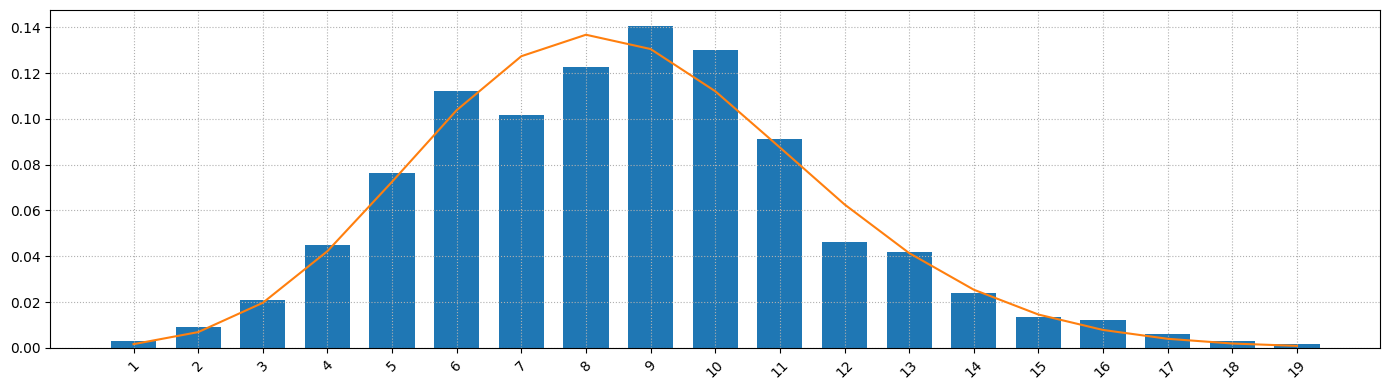

In [5]:
tmp = codes_b[codes_b.index.hour == 8]['total']
tmpv = tmp.value_counts(sort=False, normalize=True).sort_index()
mu = tmp.mean()
dist = stats.poisson(mu)
x = np.arange(tmp.min(), tmp.max()+1)
util.plot_bars(tmpv, figsize=figsize, series=pd.Series(index=x, data=dist.pmf(x)))

## Fitted Poisson Distribution

**...And finally for the peak itself (11am)**

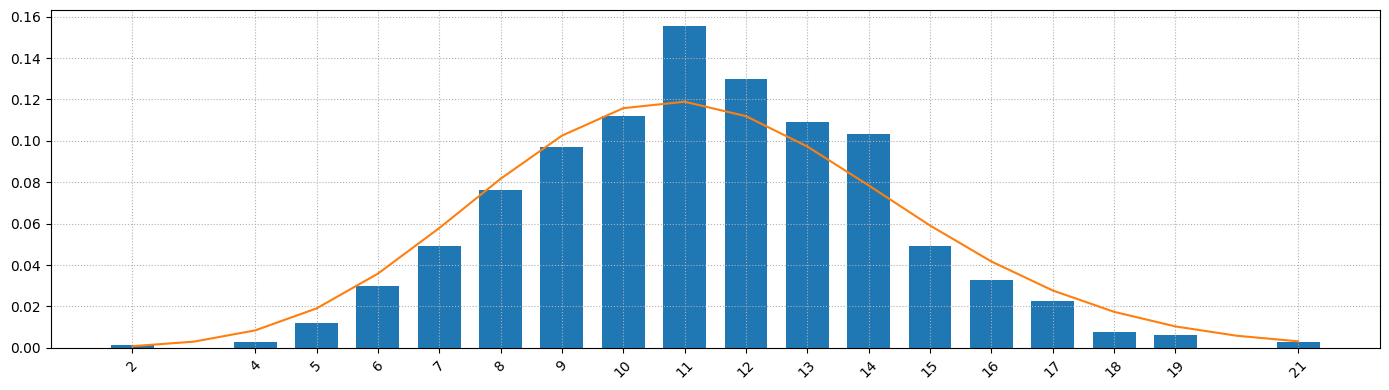

In [6]:
tmp = codes_b[codes_b.index.hour == 11]['total']
tmpv = tmp.value_counts(sort=False, normalize=True).sort_index()
mu = tmp.mean()
dist = stats.poisson(mu)
x = np.arange(tmp.min(), tmp.max()+1)
util.plot_bars(tmpv, figsize=figsize, series=pd.Series(index=x, data=dist.pmf(x)))

# Neuro-Probabilistic Models

## Learning and Estimator

> **How can we build an estimator for our problem?**

**We could build a table**

For example, we could compute average arrivals for every hour of the day

* These correspond to $\lambda$ for that hour, so we target the correct distribution
* ...But the approach has trouble scaling to multiple features

**We could train a regressor as usual**

For example a Linear Regressor or a Neural Network, with the classical MSE loss

* If we do this, it's easy to include multiple input features
* ...But we would be targeting the wrong type of distribution!

## Neuro-Probabilistic Models

**In practice there is an alternative**

Let's start by build a _probabilistic model_ of our phenomenon:

$$
y \sim \text{Pois}(\lambda(x))
$$

* The number arrivals in a 1-hour bin (i.e. $y$)
* ...Is _drawn from a Poisson distribution_ (parameterized with a rate)
* ...But _the rate is a function_ of known input, i.e. $\lambda(x)$

**Then we can approximate lambda using an estimator**, leading to:

$$
y \sim \text{Pois}(\lambda(x, \theta))
$$

* $\lambda(x, \theta)$ can be any model, with parameter vector $\lambda$

This is a _hybrid_ approach, combining statistics and ML

## Neuro-Probabilistic Models

**How do we train this kind of model?**

With same principle as usual, i.e. for (empirical) maximum log likelihood:

$$
\mathop{\text{argmin}}_\theta - \sum_{i=1}^m \log f(\hat{y}_i, \lambda(\hat{x}_i, \theta))
$$

* Where $f(\hat{y}_i, \lambda)$ is the probability of value $\hat{y}_i$ according to the distribution
* ...And $\lambda(\hat{x}_i, \theta)$ is the estimate rate for the input $\hat{x}_i$

**The difference is that in our case the formula is unusual:**

$$
\mathop{\text{argmin}}_\theta - \sum_{i=1}^m \log \frac{\lambda^{\hat{y}_i} e^{-\lambda(\hat{x}_i, \theta)}}{\hat{y}_i!}
$$

## Building a Neuro-Probabilistic Model

**We deal with this situation by using a _distribution layer_ in the NN**

```python
def build_nn_poisson_model(input_shape, hidden, rate_guess=1):
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    log_rate = layers.Dense(1, activation='linear')(x)
    lf = lambda t: tfp.distributions.Poisson(rate=rate_guess * tf.math.exp(t))
    model_out = tfp.layers.DistributionLambda(lf)(log_rate)
    model = keras.Model(model_in, model_out)
    return model
```

* An MLP architecture computes the `log_rate` tensor (corresponding to $\log \lambda(x)$)
* Using a log, we make sure the rate is _strictly positive_
* A `DistributionLambda` yield the output (a distribution object)

## Training a Neuro-Probabilistic Model

**Training the model requires to specify the loss function**

...Which in our case is the _negative log-likelihood_

* So, it turns out we do need a custom loss functions
* ...But with TFP this is easy to compute

**In particular, as loss function we _always_ use:**

```python
negloglikelihood = lambda y_true, dist: -dist.log_prob(y_true)
```

* The first parameter is the observed value (e.g. actual number of arrivals)
* The second is the distribution computed by the `DistributonLambda` layer
* ...Which provides the method `log_prob`

## Data Preparation

**Let's see the approach in practice**

We will start by preparing our data:

* As input we will use the field `weekday` in natural form
* ...And the field `hour` using a one-hot encoding

**Let's perform the encoding:**

In [18]:
np_data = pd.get_dummies(codes_bt, columns=['hour'], dtype=np.int32)
np_data.iloc[:2]

,green,red,white,yellow,total,month,weekday,hour_0,hour_1,hour_2,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
Triage,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,2,0,2,0,4,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 01:00:00,7,1,1,1,10,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Data Preparation

**Now we can separate the training and test data**

In [19]:
sep = '2019-01-01'
np_tr = np_data[np_data.index < sep]
np_ts = np_data[np_data.index >= sep]

**...And then the input and output**

In [20]:
in_cols = [c for c in np_data.columns if c.startswith('hour')] + ['weekday']
out_col = 'total'

np_tr_in = np_tr[in_cols].copy()
np_tr_in['weekday'] = np_tr_in['weekday'] / 6
np_tr_out = np_tr[out_col].astype('float64')

np_ts_in = np_ts[in_cols].copy()
np_ts_in['weekday'] = np_ts_in['weekday'] / 6
np_ts_out = np_ts[out_col].astype('float64')

## Data Preparation

**The input data need to be standardized/normalized as usual**

In our case, we do this only for weekday (the hours are already $\in \{0, 1\}$)

```python
np_tr_in['weekday'] = np_tr_in['weekday'] / 6
```

**The output does not require standarization**

...But we need to represent it using floating point numbers

```python
np_tr_out = np_tr[out_col].astype('float64')
```

* This is an implementation requirement for TensorFlow

## Building the Model

**We can now build the Neuro-Probabilistic model**

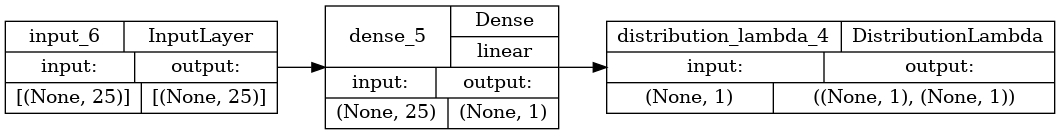

In [21]:
nnp = util.build_nn_poisson_model(input_shape=len(in_cols), hidden=[], rate_guess=np_tr_out.mean())
util.plot_nn_model(nnp)

As a rate guess we use the average over the training set

* This is easy to compute
* ...And will provide a better starting point for gradient descent

## Training the Model

**We can train the model (mostly) as usual**

...Except that we need to use the mentioned custom loss function

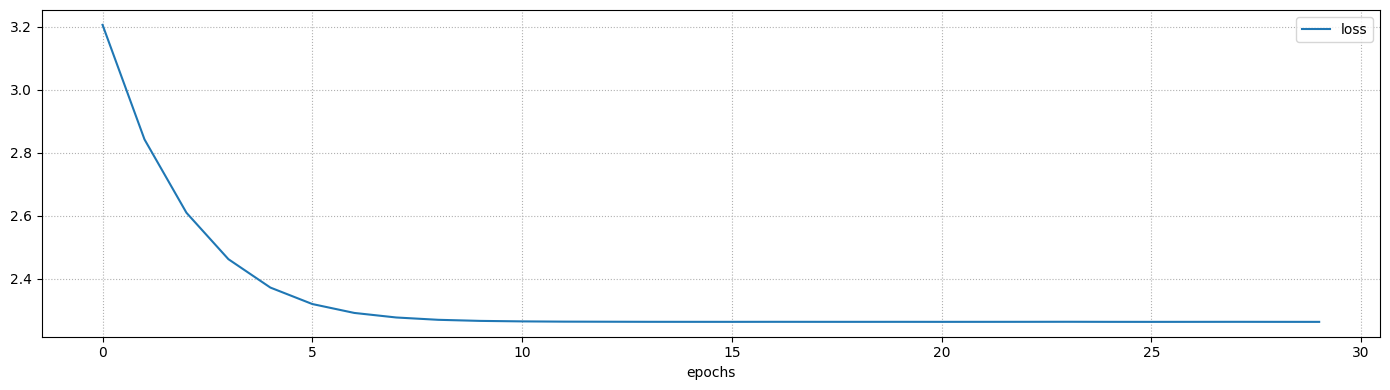

Final loss: 2.2627 (training)


In [22]:
negloglikelihood = lambda y_true, dist: -dist.log_prob(y_true)
nnp = util.build_nn_poisson_model(input_shape=len(in_cols), hidden=[], rate_guess=np_tr_out.mean())
history = util.train_nn_model(nnp, np_tr_in, np_tr_out, loss=negloglikelihood, validation_split=0.0, batch_size=32, epochs=30)
util.plot_training_history(history, figsize=figsize)

## Predictions

**When we call the `predict` method on the model we obtain _samples_**

This means that the result of `predict` is _stochastic_

In [23]:
print(str(nnp.predict(np_tr_in, verbose=0)[:3]).replace('\n', ' '))
print(str(nnp.predict(np_tr_in, verbose=0)[:3]).replace('\n', ' '))

[[6.]  [4.]  [1.]]
[[4.]  [2.]  [1.]]


**We can obtain the distribution object by simply _calling the model_**

In [24]:
nnp(np_tr_in.values)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[8760, 1] event_shape=[] dtype=float32>

* Then we can call _methods over the distribution objects_
* ...To obtain means, standard deviations, and any other relevant statistics

## Evaluation

**Using the predict means, let's check the quality of our results**

R2: 0.60
MAE: 1.93


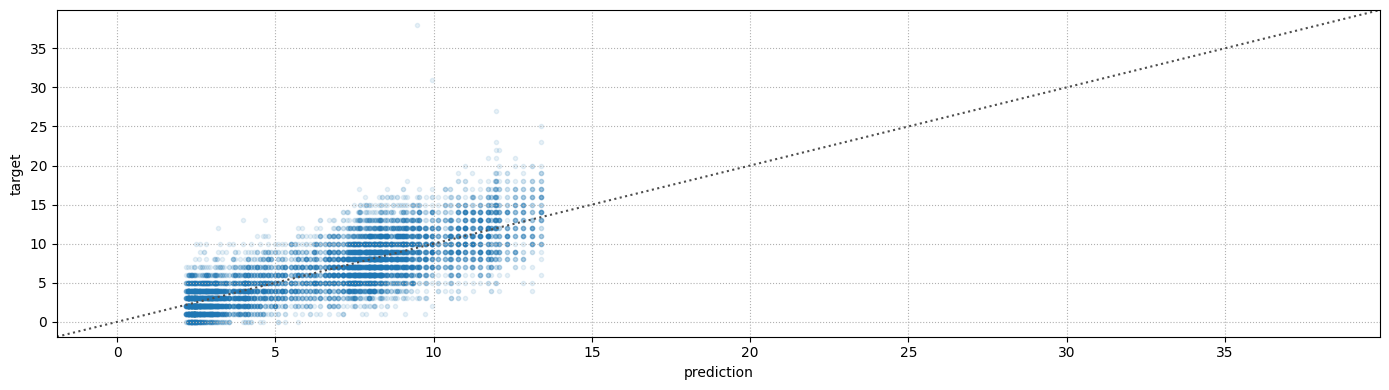

In [27]:
tr_pred = nnp(np_tr_in.values).mean().numpy().ravel()
util.plot_pred_scatter(np_tr_out, tr_pred, figsize=figsize)

* This is a _stochastic_ process, making this $R^2$ value _very good_
* When the stochasticity is too high, using the $R^2$ _might not even be viable_

## Evaluation

**Let's repeat the exercise on the test set**

R2: 0.60
MAE: 1.94


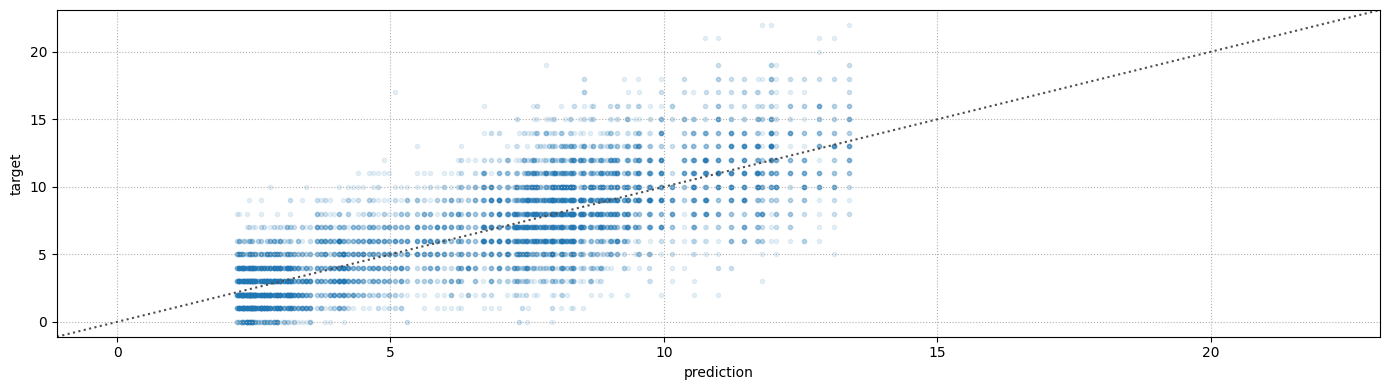

In [28]:
ts_pred = nnp(np_ts_in.values).mean().numpy().ravel()
util.plot_pred_scatter(np_ts_out, ts_pred, figsize=figsize)

* No overfitting, which is again very good

## Confidence Intervals

**Since our output is a distribution, we have access to _all sort of statistics_**

Here we will simply show the mean and stdev over one week of data:

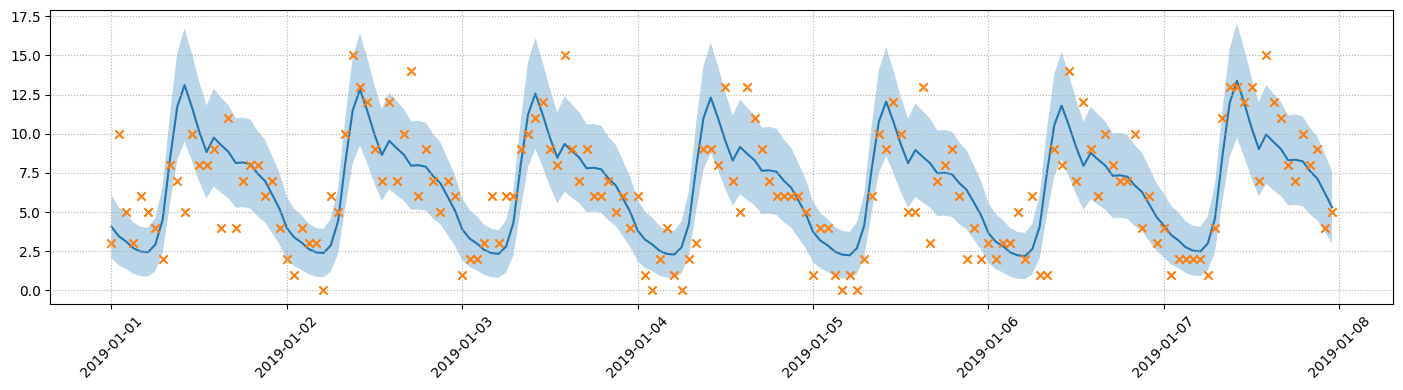

In [29]:
ts_pred_std = nnp(np_ts_in.values).stddev().numpy().ravel()
util.plot_series(pd.Series(index=np_ts_in.index[:24*7], data=ts_pred[:24*7]), std=pd.Series(index=np_ts_in.index[:24*7], data=ts_pred_std[:24*7]), figsize=figsize)
plt.scatter(np_ts_in.index[:24*7], np_ts_out[:24*7], marker='x');

## Some Remarks

**This is a very flexible approach**

...And it is not restricted to the Poisson distribution

* If you are investigating extreme phenomema
  - Then it is typical to aggregate target values using a maximum
  - ...And you can use a [Gumbel](https://en.wikipedia.org/wiki/Gumbel_distribution) or [GEV](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution) distribution
* If you are interested in inter-arrival times
  - Then you may try and [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution)
* Even when you expect a Normal distribution
  - ...You may want your model to estimate a stddev, rather than just a mean
  - There will be an example in the next notebook
* If you are studying survival (e.g. medical applications or equipment)
  - Then you may want to use a [Negative Binomial Distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution)
  - ...Or you can use the other approach from the next notebook